<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/modelado-tres-modos/5_PSO_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import json

In [ ]:

def PSO_CS(modelo_1,modelo_2,datos_reales):
  # Definir la función objetivo (por ejemplo, minimizar el error cuadrático medio)
  def  funcion_objetivo(pesos,modelo_1,modelo_2, datos_reales):
    modelo_1 = np.array(modelo_1)
    modelo_2 = np.array(modelo_2)
    #modelo_3 = np.array(modelo_3)
    #modelo_4 = np.array(modelo_4)
    datos_reales = np.array(datos_reales)

    resultado_ponderado = pesos[0] * modelo_1 + pesos[1] * modelo_2
    error_cuadratico = np.mean((datos_reales - resultado_ponderado)**2)

    return error_cuadratico

  # Inicialización de parámetros
  N = 50  # Tamaño de la población
  D = 2  # Dimensiones del problema
  T = 20000  # Número máximo de iteraciones
  w_max = 0.99
  w_min = 0.1
  c1 = 2.0
  c2 = 2.0
  pa = 0.25  # Probabilidad de descubrimiento
  alpha = 0.01  # Tamaño del paso para el vuelo de Lévy
  lb = 0  # Límite inferior del espacio de búsqueda
  ub = 1   # Límite superior del espacio de búsqueda

  Soluciones = []

  # Inicializar posiciones y velocidades
  posicion =np.random.dirichlet(np.ones(D), N)
  velocidades = np.random.uniform(-1, 1, (N, D))

  # Evaluar la función objetivo inicial
  funcion_parcial = partial(funcion_objetivo,modelo_1=modelo_1, modelo_2=modelo_2, datos_reales=datos_reales)
  fitness = np.apply_along_axis(funcion_parcial, 1, posicion)
  pbest_positions = np.copy(posicion)
  pbest_fitness = np.copy(fitness)
  gbest_position = posicion[np.argmin(fitness)]
  gbest_fitness = np.min(fitness)

  # Función para generar vuelos de Lévy
  def levy_flight(Lambda):
      sigma_u = (math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
                (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
      sigma_v = 1
      u = np.random.normal(0, sigma_u, D)
      v = np.random.normal(0, sigma_v, D)
      step = u / np.abs(v) ** (1 / Lambda)
      return step

  # Iteración del algoritmo PSO-CS
  for t in range(T):
      w = (w_max - ((w_max - w_min) /T )* t )

      for i in range(N):
          # Actualización de velocidad y posición (PSO)
          r1 = np.random.rand(D)
          r2 = np.random.rand(D)
          velocidades[i] = (w * velocidades[i] +
                          c1 * r1 * (pbest_positions[i] - posicion[i]) +
                          c2 * r2 * (gbest_position - posicion[i]))

          posicion[i] += velocidades[i]


          # Asegurar que las posiciones estén dentro de los límites
          posicion[i] = np.clip(posicion[i], lb, ub)
          sum_pos = np.sum(posicion[i])
          if sum_pos != 0:
              posicion[i] = posicion[i] / sum_pos  # Normalizamos
          else:
              posicion[i] = posicion[i] / 0.001  # Evita la división por cero


          # Evaluar nueva solución
          fitness[i] = funcion_parcial(posicion[i])

          # Actualizar pbest
          if fitness[i] < pbest_fitness[i]:
              pbest_positions[i] = posicion[i]
              pbest_fitness[i] = fitness[i]

          # Actualizar gbest
          if fitness[i] < gbest_fitness:
              gbest_position = posicion[i]
              gbest_fitness = fitness[i]

      # Exploración global mediante vuelo de Lévy (CS)
      for i in range(N):
          if np.random.rand() < pa:
              step_size = alpha * levy_flight(1.5)
              new_position = posicion[i] + step_size * (posicion[i] - gbest_position)
              new_position = np.clip(new_position, lb, ub)
              sum_new_pos = np.sum(new_position)
              if sum_new_pos != 0:
                  new_position = new_position / sum_new_pos
              else:
                  new_position = new_position / 0.01  # Evita la división por cero
              new_fitness = funcion_parcial(new_position)

              if new_fitness < fitness[i]:
                  posicion[i] = new_position
                  fitness[i] = new_fitness

                  # Actualizar pbest y gbest si es necesario
                  if new_fitness < pbest_fitness[i]:
                      pbest_positions[i] = new_position
                      pbest_fitness[i] = new_fitness
                  if new_fitness < gbest_fitness:
                      gbest_position = new_position
                      gbest_fitness = new_fitness

  # Resultado óptimo encontrado
  print("Mejor solución encontrada:", gbest_position)
  print("Valor de la función objetivo:", gbest_fitness)
  return  [gbest_position[0],gbest_position[1]]

<Axes: xlabel='FECHA'>

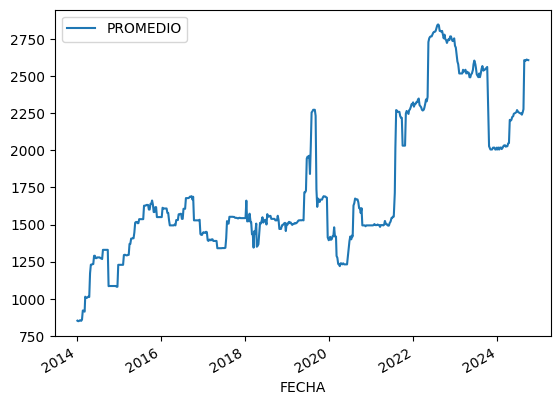

In [ ]:
datos_originales = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/precios_atlantico.csv")
#datos_originales = datos_originales.rename(columns={'Date': 'Fecha', 'Last': 'Precio_Cierre'})

datos_originales["FECHA"] =  pd.to_datetime(datos_originales["FECHA"])
datos_originales.set_index("FECHA", inplace=True)
datos_originales.plot()


In [ ]:
datos_originales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 554 entries, 2014-01-03 to 2024-09-25
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PROMEDIO  554 non-null    float64
dtypes: float64(1)
memory usage: 8.7 KB


In [ ]:
total_datos=len(datos_originales.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = datos_originales[:division_entrenamiento]
datos_validacion_originales = datos_originales[division_entrenamiento:division_validacion]
datos_testeo_originales = datos_originales[division_validacion:total_datos]

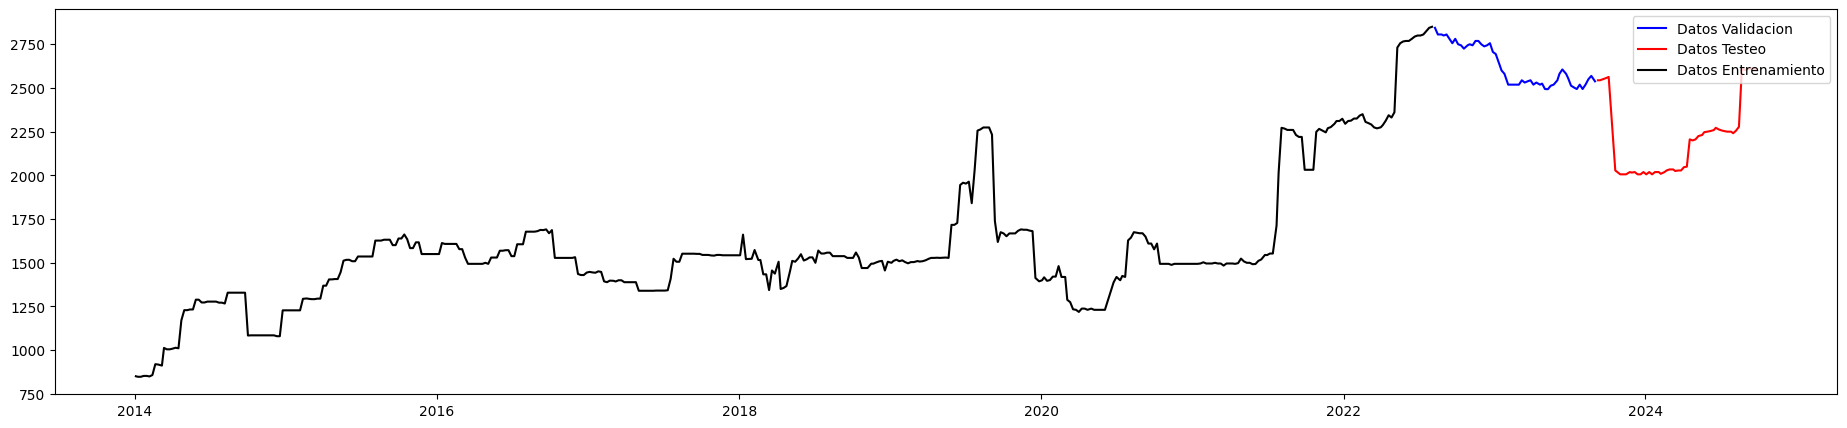

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_originales.index,datos_validacion_originales.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_originales.index,datos_testeo_originales.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_red_recurrente = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD//validacion_red_recurrente.csv')
testeo_red_recurrente = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/testeo_red_recurrente.csv')

validacion_xgboost = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/validacion_xgboost.csv')
testeo_xgboost = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/testeo_xgboost.csv')

validacion_red_densa = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/validacion_red_densa.csv')
testeo_red_densa = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/testeo_red_densa.csv')

validacion_LGBM = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/validacion_LGBM.csv')
testeo_LGBM = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/testeo_LGBM.csv')


In [ ]:
validacion_red_recurrente.sample(2)

,FECHA,PROMEDIO
12,2022-11-09,2431.7495
1,2022-08-26,2588.9277


In [ ]:
validacion_red_densa.head(5)

,FECHA,PROMEDIO
0,2022-08-17,2735.8877
1,2022-08-26,2716.9360
2,2022-08-31,2713.9268
3,2022-09-07,2704.1420
4,2022-09-14,2700.4033


In [ ]:
pesos = PSO_CS(validacion_xgboost.PROMEDIO,validacion_LGBM.PROMEDIO,datos_validacion_originales.PROMEDIO[:-1])

Mejor solución encontrada: [0.94852947 0.05147053]
Valor de la función objetivo: 718.286121995323


In [ ]:
type(pesos)

list

In [ ]:
validacion_final = (pesos[0]* validacion_xgboost.PROMEDIO +
                   pesos[1]* validacion_LGBM.PROMEDIO)

In [ ]:
diccionario_pesos = {"XGboost":pesos[0],"LGBM":pesos[1]}
with open("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Modelos/PSO_CS (1)/pesos.json", 'w') as archivo:
    json.dump(diccionario_pesos, archivo)

#json.dump( diccionario_pesos,"/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Modelos/PSO_CS/pesos.json")

In [ ]:
ecm_validacion = mean_squared_error( validacion_final,datos_validacion_originales.PROMEDIO[:-1])
recm_validacion = np.sqrt(mean_squared_error( validacion_final,datos_validacion_originales.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error(validacion_final,datos_validacion_originales.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion_final,datos_validacion_originales.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'El error cuadratico medio del modelo es: {round(ecm_validacion,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm_validacion,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam_validacion,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion} o {round(EPAM_validacion *100,2)} %")

El error cuadratico medio del modelo es: 718.29 
La raiz del error cuadratico medio del modelo es: 26.8 
el error absoluto medio del modelo es: 20.33 
Error porcentual absoluto medio del modelo es: 0.007761120219457607 o 0.78 %


In [ ]:
testeo_final = (
                0.53879814*testeo_xgboost.PROMEDIO +
                0.46120186* testeo_LGBM.PROMEDIO
                )

In [ ]:
ecm_testeo = mean_squared_error( testeo_final[:-1],datos_testeo_originales.PROMEDIO[:-1])
recm_testeo = np.sqrt(mean_squared_error( testeo_final[:-1],datos_testeo_originales.PROMEDIO[:-1]))
eam_testeo = mean_absolute_error(testeo_final[:-1],datos_testeo_originales.PROMEDIO[:-1])
EPAM_testeo = mean_absolute_percentage_error( testeo_final[:-1],datos_testeo_originales.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'El error cuadratico medio del modelo es: {round(ecm_testeo,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm_testeo,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam_testeo,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {round(EPAM_testeo,4)} o {round(EPAM_testeo * 100 , 2)} %")

El error cuadratico medio del modelo es: 3876.51 
La raiz del error cuadratico medio del modelo es: 62.26 
el error absoluto medio del modelo es: 45.96 
Error porcentual absoluto medio del modelo es: 0.021 o 2.1 %


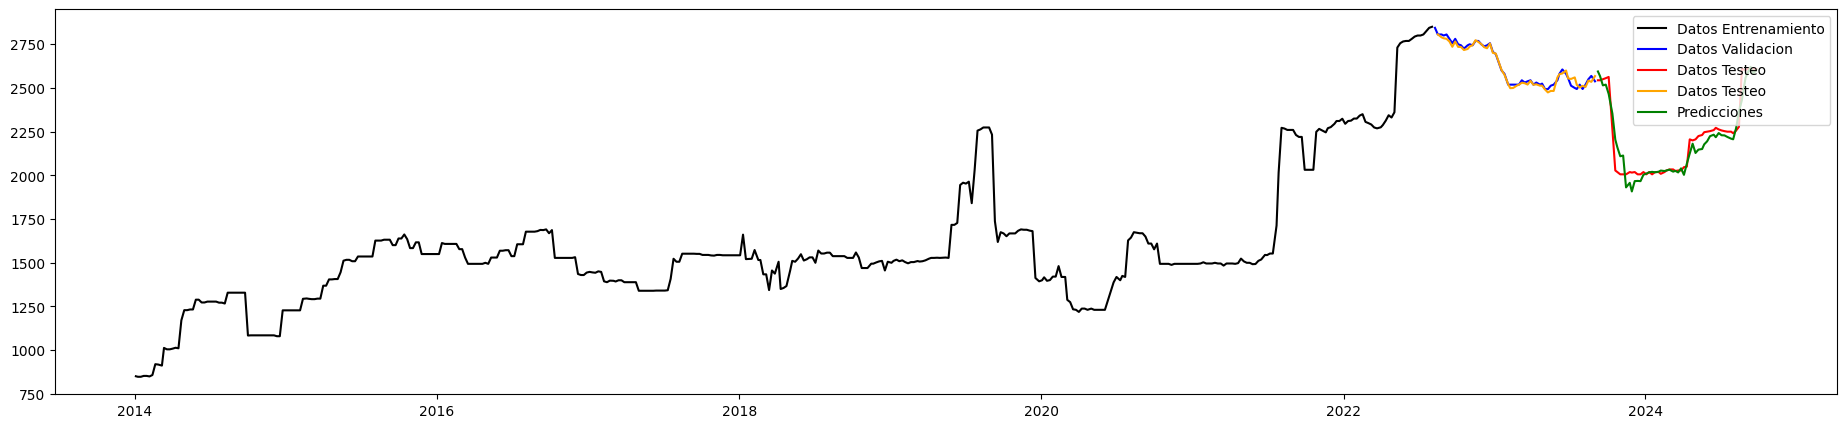

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_originales.index,datos_validacion_originales.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_originales.index,datos_testeo_originales.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_originales.index[1:],validacion_final,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo_originales.index,testeo_final,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

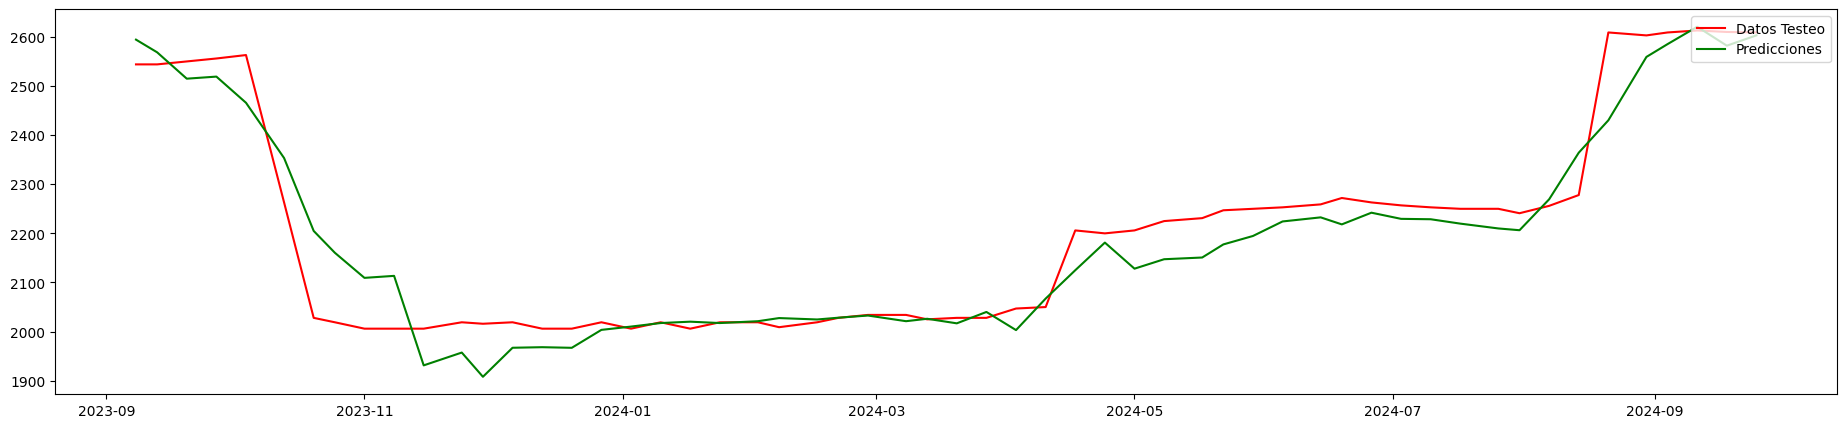

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_originales.index,datos_testeo_originales.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_originales.index,testeo_final,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()